In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import copy
import random
import time
from PIL import Image
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split


In [3]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cpu device


In [4]:
!pip install torchsummary


In [5]:
N_EPOCHS = 10
BATCH_SIZE = 128
# IMG_HEIGHT = 96
# IMG_WIDTH = 96
SEED = 1234

## For normalization required by pretrained models in torchvision.models
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

seed_everything(SEED)


In [7]:
train_dir = '../input/histopathologic-cancer-detection/train'
test_dir = '../input/histopathologic-cancer-detection/test'
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')


In [8]:
train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))

print(train_size,test_size)
print(train_labels.shape)
print(submission.shape)


174464 45561
(174464, 2)
(45561, 2)


In [9]:
display(train_labels.head())
display(submission.head())


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


,id,label
0,acfe80838488fae3c89bd21ade75be5c34e66be7,0
1,a1991e73a9b676faddd2bd47c39754b14d1eb923,0
2,94fa32b29cc1c00403176c0795fffa3cfaa0f20e,0
3,0b820b71670c039dd0a51333d1c919f471a9e940,0
4,4b7a73f1fe1dafe2ffb7d2c0b83107f060b8d693,0


In [10]:
train_labels['label'].value_counts()


label
0    103878
1     70586
Name: count, dtype: int64

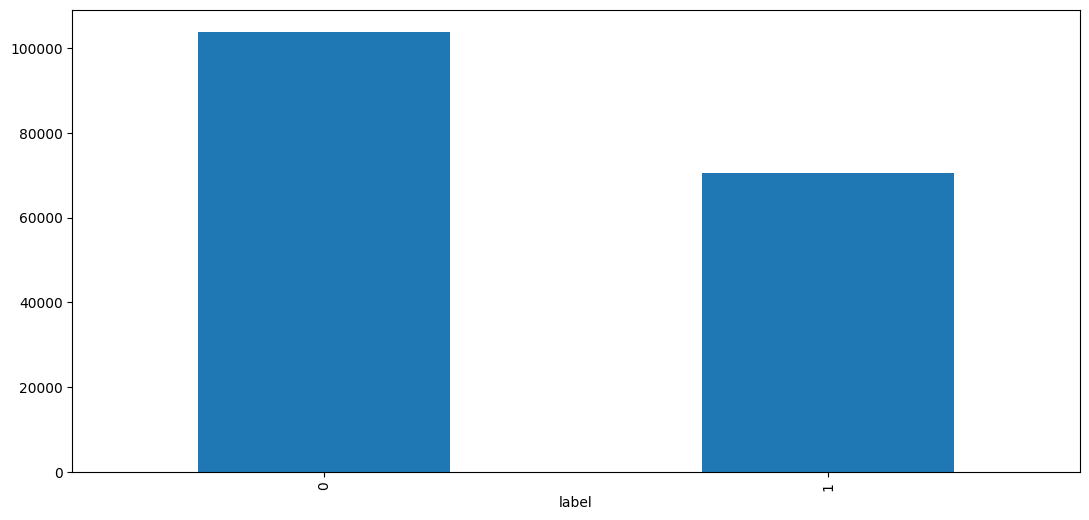

In [11]:
plt.figure(figsize=(13, 6))
train_labels['label'].value_counts().plot(kind='bar')
plt.show()


In [12]:
# get the ids of cancer cases
cancer = train_labels.loc[train_labels['label']==1]['id'].to_numpy() 

# get the ids of the normal cases
normal = train_labels.loc[train_labels['label']==0]['id'].to_numpy()


In [13]:
plt.rcParams['figure.figsize'] = (15, 6)


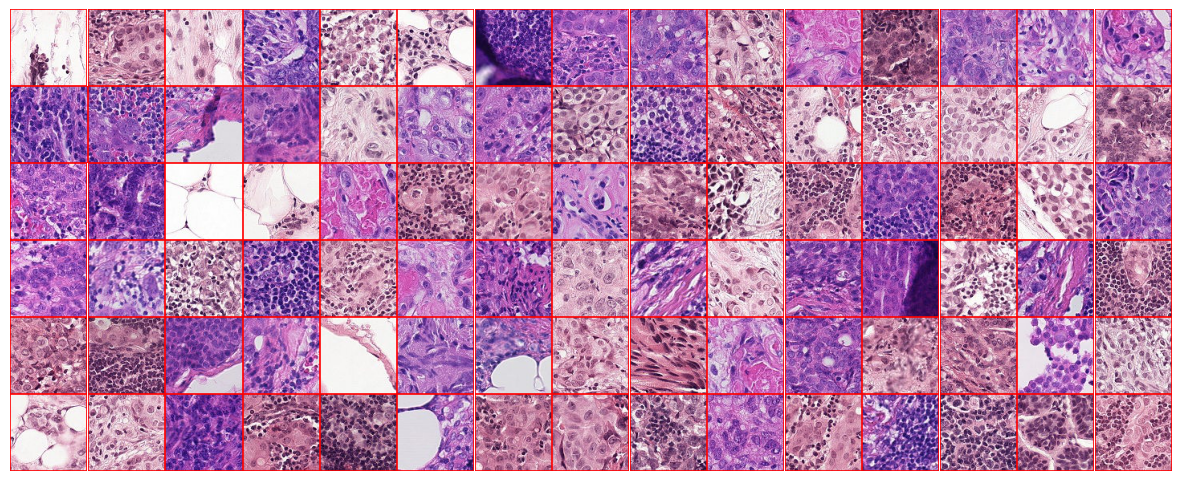

In [14]:
# Visualize cancer cases

nrows, ncols= 6, 15
plt.subplots_adjust(wspace=0, hspace=0) 

for i, image_id in enumerate(cancer[: nrows * ncols]):
    img_path = os.path.join(train_dir , image_id +'.tif')
    img = Image.open(img_path)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='red')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')


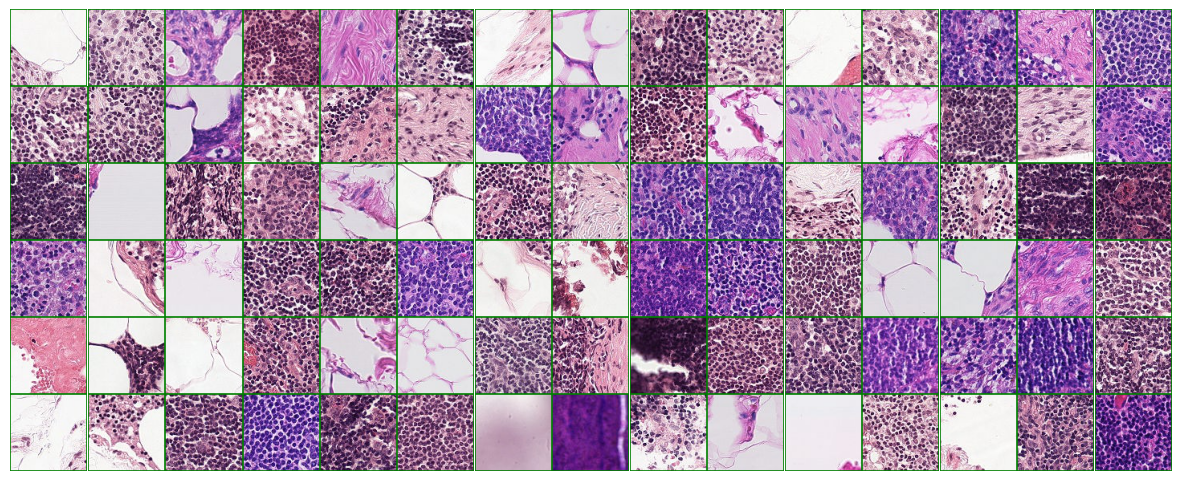

In [15]:
# Visualize Normal Cases

nrows, ncols= 6, 15
plt.subplots_adjust(wspace=0, hspace=0) 

for i, image_id in enumerate(normal[: nrows * ncols]):
    img_path = os.path.join(train_dir , image_id +'.tif')
    img = Image.open(img_path)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='green')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')


In [16]:
# class CustomDataset(Dataset):
    
#     def __init__(self, labels, img_dir, transform=None, target_transform=None):
#         self.img_labels = labels
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_name, label = self.img_labels.iloc[idx]
#         img_path = os.path.join(self.img_dir, img_name + '.tif')
#         image =  Image.open(img_path)

#         if self.transform is not None:
#             image = self.transform(image)
#         if self.target_transform is not None:
#             label = self.target_transform(label)
            
#         return image, label


In [17]:
class CustomDataset(Dataset):
    
    def __init__(self, labels, img_dir, dataset_type = 'train', transform=None, target_transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.dataset_type = dataset_type

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_id = self.img_labels.loc[idx, 'id']
        img_path = os.path.join(self.img_dir, img_id + '.tif')
        image =  Image.open(img_path)

        if self.transform is not None:
            image = self.transform(image)
            
        # For Test Dataset, we don't have class label.
        # So for Test Dataset, we will return the image 'id' as label
        label = 0
        
        if self.dataset_type == 'train':
            label = self.img_labels.loc[idx, 'label']
            
            if self.target_transform is not None:
                label = self.target_transform(label)
        
        elif self.dataset_type == 'test':
            label = img_id
            
        return image, label


In [18]:
# Define transformation that converts a PIL image into PyTorch tensors.
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])


In [19]:
# Define an instance of the custom dataset for the train folder.
dataset = CustomDataset(train_labels, train_dir, transform = data_transformer)

img, label = dataset[24]
print(img.shape, torch.min(img), torch.max(img))
print(label)


torch.Size([3, 96, 96]) tensor(0.0157) tensor(1.)
0


In [20]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split Pytorch tensor
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size]) # random split 80/20

print("train dataset size:", len(train_dataset))
print("validation dataset size:", len(valid_dataset))


train dataset size: 139571
validation dataset size: 34893


In [21]:
# Define the following transformations for the training dataset
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(20),         
#     transforms.RandomResizedCrop(96, scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()]
)


In [22]:
# For the validation dataset, we don't need any augmentation; simply convert images into tensors
valid_transformer = transforms.Compose([
    transforms.ToTensor()]
)


In [23]:
# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_dataset.transform = train_transformer
valid_dataset.transform = valid_transformer


In [24]:
# Define two dataloaders for the datasets

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=False)


In [25]:
for batch, (X, y) in enumerate(train_dataloader):
    print("Batch : {}".format(batch))
    print(X.shape)
    print(y.shape)
    
    if batch == 4:
        break


Batch : 0
torch.Size([128, 3, 96, 96])
torch.Size([128])
Batch : 1
torch.Size([128, 3, 96, 96])
torch.Size([128])
Batch : 2
torch.Size([128, 3, 96, 96])
torch.Size([128])
Batch : 3
torch.Size([128, 3, 96, 96])
torch.Size([128])
Batch : 4
torch.Size([128, 3, 96, 96])
torch.Size([128])


In [26]:
# model = models.densenet169(pretrained=True)
# model


In [27]:
class BasicCNN(nn.Module):
    
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3)
        
        self.fc1 = nn.Linear(1*1*512, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x = self.avg_pool(x)
#         print(x.shape)
        x = x.view(-1, 1 * 1 * 512)
#         print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
#         x = F.softmax(x)
        return x


In [28]:
# If we need to move a model to GPU via .cuda(), 
# we must do it before constructing optimizers for it. 
# Parameters of a model after .cuda() will be different objects with those before the call.

# In general, we should make sure that optimized parameters live in consistent locations 
# when optimizers are constructed and used.

model = BasicCNN().to(device)
model


BasicCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Bat

In [29]:
from torchsummary import summary
summary(model, input_size=(3,96,96))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
       BatchNorm2d-6           [-1, 64, 48, 48]             128
              ReLU-7           [-1, 64, 48, 48]               0
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
      BatchNorm2d-10          [-1, 128, 24, 24]             256
             ReLU-11          [-1, 128, 24, 24]               0
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
      BatchNorm2d-14          [-1, 256,

In [30]:
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(params = model.parameters(),lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(reduction='mean')


In [31]:
def train(dataloader, model, loss_fn, optimizer):
    ds_size = len(dataloader.dataset)
    num_batch = len(dataloader)
    
    total_accurate_preds = 0.0
    total_loss = 0.0
    
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        logits = model(X)
        loss = loss_fn(logits, y) # average loss per batch 
        preds = logits.argmax(dim=1)
        num_accurate_preds = (preds == y).float().sum() # number of correct predictions for a single batch
        
        total_loss += loss.item()
        total_accurate_preds += num_accurate_preds.item()
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            current = batch_idx * len(X)
            print(f"loss: {loss.item():>7f}  [{current}/{ds_size}]")

    accuracy = total_accurate_preds/ ds_size
    avg_loss = total_loss/ num_batch

    return  accuracy, avg_loss

# train(train_dataloader, model, criterion, optimizer)


In [32]:
# model.eval() will notify all your layers that we are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.

# torch.no_grad() impacts the autograd engine and deactivate it. 
# It will reduce memory usage and speed up computations 
# but we won’t be able to backprop (which we don’t want in an eval mode).

def evaluate(dataloader, model, loss_fn):
    ds_size = len(dataloader.dataset)
    num_batch = len(dataloader)
    
    total_accurate_preds = 0
    total_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Compute prediction error
            logits = model(X)
            loss = loss_fn(logits, y) # average loss per batch 
            preds = logits.argmax(dim=1)
            num_accurate_preds = (preds == y).float().sum() # number of correct predictions for a single batch
    
            total_loss += loss.item()
            total_accurate_preds += num_accurate_preds.item()
    
    accuracy = total_accurate_preds/ ds_size
    avg_loss = total_loss/ num_batch

    #     print(f"Validation Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
    
    return  accuracy, avg_loss

# evaluate(valid_dataloader, model, criterion)


In [33]:
train_history = {"loss": [],"accuracy": []} # history of accuracy and loss for train set in each epoch
validation_history = {"loss": [],"accuracy": []} # history of accuracy and loss for validation set in each epoch
best_model_weights = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
best_loss = float('inf') # initialize best loss to a large value

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}\n-------------------------------")
    
    start = time.time()
    train_accuracy, train_loss = train(train_dataloader, model, criterion, optimizer)
    train_history['loss'].append(train_loss)
    train_history['accuracy'].append(train_accuracy)
    print('Train accuracy : {}, Train loss : {}'.format(train_accuracy, train_loss))
    
    validation_accuracy, validation_loss = evaluate(valid_dataloader, model, criterion)
    validation_history['loss'].append(validation_loss)
    validation_history['accuracy'].append(validation_accuracy)
    print('Validation accuracy : {}, Validation loss : {}'.format(validation_accuracy,validation_loss))
    
    print("Execution time for an Epoch : {}".format(time.time() - start))
    
    # store best model
    if validation_loss  best_loss:
        best_loss = validation_loss
        best_model_weights = copy.deepcopy(model.state_dict())

        ## store weights into a local file
        # torch.save(model.state_dict(), weight_path)
    
print("Done!")


SyntaxError: invalid syntax (4065952900.py, line 23)

In [34]:
weight_save_path = './model.pt'
torch.save(best_model_weights, weight_save_path)
print("Saved PyTorch Best Model State to model.pt")


NameError: name 'best_model_weights' is not defined

In [35]:
# Define transformation that converts a PIL image into PyTorch tensors.
test_transformer = transforms.Compose([transforms.ToTensor()])

# Define an instance of the custom dataset for the train folder.
test_dataset = CustomDataset(submission, test_dir, dataset_type = 'test', transform = test_transformer)

img, img_id = test_dataset[24]
print(img.shape, torch.min(img), torch.max(img))
print(img_id)


torch.Size([3, 96, 96]) tensor(0.1137) tensor(1.)
14e1234a200b8ea02e86ea9630d8219aaa574d19


In [36]:
# Define a Dataloader for test dataset
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)


In [37]:
# configure model with best model weights 

# model = BasicCNN().to(device)
# model.load_state_dict(torch.load("model.pth", map_location=device))

model.load_state_dict(best_model_weights)
# print(model.state_dict())


NameError: name 'best_model_weights' is not defined

In [38]:
test_ds_size = len(test_dataloader.dataset)
cancer_probs = []

model.eval()
with torch.no_grad():
    for batch_idx, (images, image_ids) in enumerate(test_dataloader):
        images = images.to(device)
        logits = model(images)
        preds = F.softmax(logits, dim=1)[:, 1]
        preds = torch.flatten(preds).detach().cpu().numpy()
        cancer_probs += list(zip(list(image_ids), preds))
        
        if batch_idx % 100 == 0:
            current = batch_idx * len(images)
            print(f"Prediction Done:  [{current}/{test_ds_size}]")    


Prediction Done:  [0/45561]
Prediction Done:  [12800/45561]
Prediction Done:  [25600/45561]
Prediction Done:  [38400/45561]


In [39]:
idx = list(map(lambda x: x[0], cancer_probs))
prob = list(map(lambda x: x[1], cancer_probs))
submission = pd.DataFrame({'id':idx, 'label':prob})

submission.to_csv('submission.csv',index=False)
